# DATA MERGING AND VALIDATION FOR CREDIT RISK ANALYSIS

We will begin by importing relevant libraries, importing and joining the datasets and exploring some missingness of the data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import pickle
import numpy as np

In [2]:
trans = pd.read_csv('trans.asc',sep=';')
client = pd.read_csv('client.asc',sep=';')
account = pd.read_csv('account.asc',sep=';')
disp = pd.read_csv('disp.asc',sep=';')
order = pd.read_csv('order.asc',sep=';')
loan = pd.read_csv('loan.asc',sep=';')
card = pd.read_csv('card.asc',sep=';')
district = pd.read_csv('district.asc',sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Reading and merging the loan and account -related datasets
We merge the static datasets and explore proportional missingness in the full data.

In [3]:
df = pd.merge(loan, account,on='account_id', suffixes=['_loan','_acnt'], how='outer')
df = pd.merge(df, disp, on='account_id', how='outer')
df = pd.merge(df, client, on='client_id', how='outer', suffixes = ['_clnt','_acnt'])
df = pd.merge(df, district, left_on='district_id_clnt', right_on='A1', how='outer')
df = pd.merge(df, card, on='disp_id', how='outer', suffixes=['', '_card'])

In [4]:
print(np.sum(df.isna())/len(df))
print('\nThere are {} loans in the data.'.format(len(df.loan_id.unique())))

loan_id             0.845968
account_id          0.000000
date_loan           0.845968
amount              0.845968
duration            0.845968
payments            0.845968
status              0.845968
district_id_clnt    0.000000
frequency           0.000000
date_acnt           0.000000
disp_id             0.000000
client_id           0.000000
type                0.000000
birth_number        0.000000
district_id_acnt    0.000000
A1                  0.000000
A2                  0.000000
A3                  0.000000
A4                  0.000000
A5                  0.000000
A6                  0.000000
A7                  0.000000
A8                  0.000000
A9                  0.000000
A10                 0.000000
A11                 0.000000
A12                 0.000000
A13                 0.000000
A14                 0.000000
A15                 0.000000
A16                 0.000000
card_id             0.833861
type_card           0.833861
issued              0.833861
dtype: float64

There are relatively few loans available in the datasets, and most accounts do not have a loan associated with them.
The missingness of credit card data is no issue, as the type and issue date of cards are likely not relevant to the problem.



### Feature generation for loans

We first drop observations on users that do not have a loan associated in any of the accounts they participate in.

We also drop some irrelevant columns. Most of the identification was only necessary for joining the data, so they are dropped. Most of the demographic data describes essentially the population and urbanization in the area, so this redundant information is dropped.
There are only 5 junior and 3 gold cards in the data so the card type is dropped as well.

We then encode features into formats suitable for machine learning.
WE CREATE

The demographic data is available only as static values measured after some of the loans in the data are already issued. Because ex-ante values are not available, we make the assumption that  the demographics do not drastically change across years. However, if the demographics turn out to be important in predicting credit defaults, this problem should be readdressed.

In [5]:
loans = df[~pd.isna(df.loan_id)]

loans.drop(['account_id','district_id_acnt', 'A1', 'A2', 'A3',
            'A5','A6', 'A7', 'A8', 'A9','district_id_clnt', 'disp_id',
            'client_id', 'card_id', 'type_card'], axis=1, inplace=True)


#create dummy for whether the loan completed successfully
loans['target'] = (loans.status == 'B').astype(int) + (loans.status == 'D').astype(int)

#convert date columns to datetime
loans['date_loan'] = pd.to_datetime(loans.date_loan, format='%y%m%d')
loans['issued'] = pd.to_datetime(loans.issued.str[:6])
loans['date_acnt'] = pd.to_datetime(loans.date_acnt, format='%y%m%d')

#find gender (encoded into the birthnumber) and convert birthdate into datetime
loans['gender'] = (loans.birth_number % 10000 > 5000).astype(int)
loans['birthdate'] = loans.birth_number - 5000 * loans.gender + 19000000
loans['birthdate'] = pd.to_datetime(loans.birthdate, format='%Y%m%d')

#find the age of applicant and the account at the time of loan issuance
loans['appl_age'] = (loans.date_loan - loans.birthdate).dt.days / 365.25
loans['accnt_age'] = (loans.date_loan - loans.date_acnt).dt.days / 365.25



#create dummy for whether the account has an associated card at the time of loan issuance
loans['issued'] = (loans.issued < loans.date_loan).astype(int)

#create dummies for the frequency of statement issuance and the account type
loans = pd.get_dummies(loans, columns=['frequency', 'type'], drop_first=True)


# select unemployment and crime from the demographic statistics.
loans['unempl'] = np.select([loans.date_loan.dt.year > 1996,
                             loans.date_loan.dt.year < 1997],
                            [loans.A13, loans.A12])

loans['crime'] = np.select([loans.date_loan.dt.year > 1996, loans.date_loan.dt.year < 1997],
          [loans.A16, loans.A15])

# convert the columns to numeric values and scale the crime numbers for population
loans['unempl'] = pd.to_numeric(loans.unempl, errors='coerce')
loans['crime'] = pd.to_numeric(loans.crime, errors='coerce') / loans.A4
loans['A14'] = loans.A14 / loans.A4 * 100

#finally, aggregate to loan-level from client-level data
loans = loans.groupby('loan_id').agg('mean')
loans['multi'] = np.select([loans.type_OWNER < 1], [1], 0)

#drop unnecessary columns
loans.drop(['birth_number','type_OWNER','A13','A16'], axis=1, inplace=True)

In [6]:
loans.columns = ['amount', 'duration', 'payments', 'pop', 'urban_rat', 'avg_sal', 'rat_urban', 'card',
       'target', 'gender', 'appl_age', 'accnt_age',
       'freq_trans', 'freq_weekly', 'unempl',
       'crime', 'multi']

In [7]:
print(np.sum(loans.isna()))
print('\nThere are {} loans in the data.'.format(len(loans)))

amount         0
duration       0
payments       0
pop            0
urban_rat      0
avg_sal        0
rat_urban      0
card           0
target         0
gender         0
appl_age       0
accnt_age      0
freq_trans     0
freq_weekly    0
unempl         3
crime          3
multi          0
dtype: int64

There are 682 loans in the data.


### Read in and merge transaction data

Note that, because the dataset is relatively small, we introduce some redundancy for a while by joining the full dataset of static information. 
This is done to spare lines of code.

In [8]:
trans = pd.read_csv('trans.asc', sep=';')

In [9]:
trans = pd.merge(trans, df, on='account_id', suffixes=['_trans', ''], how='left')
#Subset the data set to transactions for accounts with loans:
trans_loans = trans[~pd.isna(trans.loan_id)]

In [10]:
print('Total transactions: ', len(trans))
print('Transactions for accounts associated with a loan: ', len(trans_loans))

Total transactions:  1262625
Transactions for accounts associated with a loan:  233627


### Datetime wrangling

Because we're interested in predicting bad loans, we should use transaction data from only prior to giving out the loan.
In order to work with the dates, we will first transform them to datetime format

In [11]:
trans_loans.date = pd.to_datetime(trans_loans.date, format='%y%m%d')
trans_loans.date_loan = pd.to_datetime(trans_loans.date_loan, format='%y%m%d')

#filter to transactions prior to loan issuance
trans_loans = trans_loans[trans_loans.date < trans_loans.date_loan]

print('We end up with {} ex-ante transactions for our final data.'.format(len(trans_loans)))

We end up with 66762 ex-ante transactions for our final data.


### Explore missingness in the transaction data 

In [12]:
print(np.sum(trans.isna())/len(trans))

trans_id            0.000000
account_id          0.000000
date                0.000000
type_trans          0.000000
operation           0.172902
amount_trans        0.000000
balance             0.000000
k_symbol            0.451296
bank                0.733849
account             0.713619
loan_id             0.814967
date_loan           0.814967
amount              0.814967
duration            0.814967
payments            0.814967
status              0.814967
district_id_clnt    0.000000
frequency           0.000000
date_acnt           0.000000
disp_id             0.000000
client_id           0.000000
type                0.000000
birth_number        0.000000
district_id_acnt    0.000000
A1                  0.000000
A2                  0.000000
A3                  0.000000
A4                  0.000000
A5                  0.000000
A6                  0.000000
A7                  0.000000
A8                  0.000000
A9                  0.000000
A10                 0.000000
A11           

In [13]:
print(np.sum(trans_loans.isna())/len(trans_loans))

trans_id            0.000000
account_id          0.000000
date                0.000000
type_trans          0.000000
operation           0.172883
amount_trans        0.000000
balance             0.000000
k_symbol            0.582322
bank                0.815763
account             0.706180
loan_id             0.000000
date_loan           0.000000
amount              0.000000
duration            0.000000
payments            0.000000
status              0.000000
district_id_clnt    0.000000
frequency           0.000000
date_acnt           0.000000
disp_id             0.000000
client_id           0.000000
type                0.000000
birth_number        0.000000
district_id_acnt    0.000000
A1                  0.000000
A2                  0.000000
A3                  0.000000
A4                  0.000000
A5                  0.000000
A6                  0.000000
A7                  0.000000
A8                  0.000000
A9                  0.000000
A10                 0.000000
A11           

Bank and account columns report the bank and account of a partner in a transaction. As such, the specific bank and of a partner are likely not relevant and missingness should not be an issue.

Because we want to utilize the transactions for predicting credit defaults, transaction types are intuitively important. The operation and k_symbol columns describe the transaction type. We will explore the missing operation data further by examining, whethere there are cases where both operation and k_symbol are missing:

In [14]:
print('Percentage of cases where both operation and k_symbol are missing: ')
print(np.sum(trans.operation.isna() & trans.k_symbol.isna())/len(trans))
print('Percentage of cases where both operation and k_symbol are reported: ')
print(np.sum(~trans.operation.isna() & ~trans.k_symbol.isna())/len(trans))

print('Percentage of cases where both operation and k_symbol are missing: ')
print(np.sum(trans_loans.operation.isna() & trans_loans.k_symbol.isna())/len(trans))
print('Percentage of cases where both operation and k_symbol are reported: ')
print(np.sum(~trans_loans.operation.isna() & ~trans_loans.k_symbol.isna())/len(trans))

Percentage of cases where both operation and k_symbol are missing: 
0.0
Percentage of cases where both operation and k_symbol are reported: 
0.3758019998019998
Percentage of cases where both operation and k_symbol are missing: 
0.0
Percentage of cases where both operation and k_symbol are reported: 
0.012943668943668944


We see that, while operation and k_symbol are missing at times, there are no cases where neither one is present. Thus, missingness should be no issue.

Because missing data is not an issue and we do not need to use the transaction data to predict missing values, we can focus on the subset of the transactions data, where there are loans present.



## Aggregating transactions

For now, we'll drop the other info and focus on aggregating the transactions data to loan-level.

First, we drop irrelevant columns and generate some dummy variables.

In [15]:
trans_loans = trans_loans[['loan_id', 'date','date_loan', 'type_trans', 'operation',
       'amount_trans', 'balance', 'k_symbol']]

trans_loans = trans_loans[trans_loans.k_symbol != 'UROK']
trans_loans = trans_loans[trans_loans.k_symbol != 'SLUZBY']
trans_loans.k_symbol.fillna(trans_loans.operation, inplace=True)

trans_loans['b_deposit'] = trans_loans.k_symbol.str.contains('PREVOD Z').astype(int)
trans_loans['c_deposit'] = trans_loans.k_symbol.str.contains('VKLAD').astype(int)
trans_loans['withdr'] = trans_loans.k_symbol.str.contains('VYBER').astype(int)
trans_loans['sanc'] = trans_loans.k_symbol.str.contains('SANK').astype(int)
trans_loans['b_withdr'] = trans_loans.operation.str.contains('PREVOD NA').astype(int)

trans_loans.drop(['type_trans','operation','k_symbol'], axis=1, inplace=True)

In [76]:
(trans_loans.date_loan - trans_loans.date).dt.days


81         313
91         312
94         244
100        297
101        297
          ... 
1230542      2
1234908      3
1234911      3
1235338      3
1236988      3
Length: 48229, dtype: int64

In [79]:
def aggregate(data, time_window_max = 100, time_window_min = 0):  
    trans_agg = data[(data.date_loan - data.date).dt.days < time_window_max]
    trans_agg = trans_agg[(data.date_loan - data.date).dt.days > time_window_min]
    trans_agg['balance_start'] = trans_agg.balance - trans_agg.amount_trans
    trans_agg['transactions'] = 1
    trans_agg['net_cdeposit'] = trans_agg.c_deposit * trans_agg.amount_trans \
                                - trans_agg.withdr * trans_agg.amount_trans
    trans_agg['net_bdeposit'] =  trans_agg.b_deposit * trans_agg.amount_trans \
                                - trans_agg.b_withdr * trans_agg.amount_trans
    trans_agg['age'] = (trans_loans.date_loan - trans_loans.date).dt.days
    trans_agg = trans_agg.groupby('loan_id').agg({
        'balance':['min','mean','max'],
        'c_deposit':'sum',
        'withdr':'sum',
        'sanc':'max',
        'balance_start':lambda x: x.iloc[0],
        'transactions':'sum',
        'net_cdeposit':'sum',
        'net_bdeposit':['sum','max'],
        'age':'mean'
    })
    trans_agg.columns = ['_'.join(col).strip() for col in trans_agg.columns.values]

    trans_agg['balance_max'] = trans_agg[['balance_max', 'balance_start_<lambda>']].max(axis=1)
    trans_agg['balance_min'] = trans_agg[['balance_min', 'balance_start_<lambda>']].min(axis=1)
    trans_agg.drop(['balance_start_<lambda>'], axis=1, inplace=True)
    trans_agg.
    return trans_agg

In [80]:
trans_agg = aggregate(trans_loans, 300, 30)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
trans_agg.loc[:,['c_deposit_sum', 'withdr_sum', 'transactions_sum','net_cdeposit_sum',
       'net_bdeposit_sum']] = trans_agg[['c_deposit_sum', 'withdr_sum',
        'transactions_sum', 'net_cdeposit_sum', 'net_bdeposit_sum']].div(trans_agg.age_mean, axis=0)


### Merge transaction and loan datasets, export

In [91]:
final = pd.merge(loans, trans_agg, left_index=True, right_index=True, suffixes=['','_trans'], how='left')



with open('loan_data','wb') as file:
    pickle.dump(final, file)

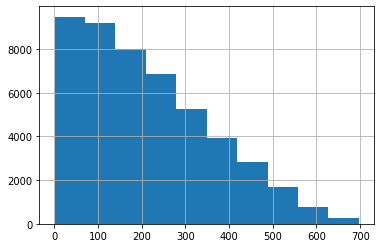

In [53]:
(trans_loans.date_loan - trans_loans.date).dt.days.hist()